In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import libraries**

In [ ]:
import torch
from torchvision.models.video import r3d_18
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import cv2
import networkx as nx
import os
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
data = np.load("/content/drive/MyDrive/WLASL/start_kit/npzs/05729.npz")

print(data['features'].shape)

(100, 19968)


### **Load I3D Model**

In [ ]:
i3d_model = r3d_18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Temporal pooling function**

In [ ]:
def temporal_pooling_inter(video_path, fixed_length):
    # Load the video frames
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize variables
    pooled_frames = []

    # Iterate over frames and resize them to (240,320)
    for i in range(frame_count):
        ret, frame = cap.read()

        # If the frame is not available, break the loop
        if not ret:
            break

        # Resize the frame to (240,320)
        frame = cv2.resize(frame, (320,240))

        # Append the resized frame to pooled_frames
        pooled_frames.append(frame)

    # Calculate the interpolation factor
    interpolation_factor = len(pooled_frames) // (fixed_length - 1)

    # Initialize variables
    interpolated_frames = []

    # Iterate over frames and perform temporal pooling with interpolation
    for i in range(fixed_length):
        frame_idx = i * interpolation_factor

        # Calculate the previous and next frame indices
        prev_frame_idx = int(frame_idx)
        next_frame_idx = prev_frame_idx + 1

        # If either frame is not available, break the loop
        if prev_frame_idx >= len(pooled_frames) or next_frame_idx >= len(pooled_frames):
            break

        # Read the previous and next frames
        prev_frame = pooled_frames[prev_frame_idx]
        next_frame = pooled_frames[next_frame_idx]

        # Calculate the interpolation weight
        weight = frame_idx - prev_frame_idx

        # Perform linear interpolation between frames
        interpolated_frame = (1 - weight) * prev_frame + weight * next_frame

        # Append the interpolated frame to interpolated_frames
        interpolated_frames.append(interpolated_frame)

    # Convert the interpolated frames to a numpy array
    interpolated_frames = np.array(interpolated_frames)
    return interpolated_frames

### **Extract video features functions**

In [ ]:
def extract_video_features(video_path, model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    i3d_model.eval()

    frames = temporal_pooling_inter(video_path, 100)
    print(frames.shape)
    tensor_frames = [transform(Image.fromarray(frame)) for frame in frames]
    tensor_frames = torch.stack(tensor_frames)
    tensor_frames = tensor_frames.unsqueeze(0)  # Add a batch dimension
    tensor_frames = tensor_frames.permute(0, 2, 1, 3, 4)  # Adjust the dimensions to match the expected input shape

    print(tensor_frames.shape)

    intermediate_output = None
    for name, module in i3d_model.named_children():
        tensor_frames = module(tensor_frames)
        if name == 'layer4':
            intermediate_output = tensor_frames
            break  # Stop iterating further
        del module

    if intermediate_output is not None:
        features = intermediate_output.squeeze(0)  # Remove the batch dimension
        print("Shape of features:", features.shape)

        features = features.view(100, -1)
        print("Shape of features:", features.shape)
        print(features)

    return features

### **Frame graph function**

In [ ]:
def create_frame_graph(frames, window_size):
    num_frames = len(frames)

    # Create an empty graph
    graph = nx.Graph()

    # Add nodes representing frames to the graph
    for frame_idx in range(num_frames):
        graph.add_node(frame_idx)

    # Add edges between frames based on sliding window approach
    for i in range(num_frames - window_size):
        start_frame_idx = i
        end_frame_idx = i + window_size

        # Add edges between frames within the sliding window
        for j in range(start_frame_idx, end_frame_idx):
            for k in range(j+1, end_frame_idx+1):
                graph.add_edge(j, k)

    return graph

### **Labelling**

In [ ]:
import os
main_folder_path = '/content/drive/MyDrive/WLASL/start_kit/preprocessed_videos'

# Get the list of subfolders (classes)
class_folders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))]

# Perform label encoding on the subfolders
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(class_folders)

# Create a dictionary to map the subfolder name to the encoded label
label_dict = dict(zip(class_folders, encoded_labels))

In [ ]:
label_dict

{'book': 1,
 'before': 0,
 'go': 6,
 'candy': 3,
 'cousin': 5,
 'corn': 4,
 'school': 7,
 'work': 9,
 'brown': 2,
 'small': 8}

In [ ]:
def process_video(videopath, label_dict):
    # Extract the subfolder name from the videopath
    subfolder_name = os.path.basename(os.path.dirname(videopath))

    # Get the encoded label for the subfolder
    encoded_label = label_dict[subfolder_name]

    # Create a one-hot encoded label vector
    one_hot_label = np_utils.to_categorical(encoded_label, num_classes=len(label_dict))

    return one_hot_label

### **Loops over the videos to create npz files and restarts runtime and runs all cells after each video.**

In [ ]:
import os
from IPython.display import display, Javascript

def restart_runtime():
    display(Javascript('google.colab.kernel.restart();'))

def run_all_cells():
    display(Javascript('''
        var cells = document.querySelectorAll('.cell.code');
        cells.forEach((cell) => {
            cell.dispatchEvent(new Event('run'));
        });
    '''))

# Function to process a single video and create feature adjacency label
def create_feature_adjacency_label(video_path, label_dict):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    features = extract_video_features(video_path, i3d_model)

    # Create the frame graph
    frame_graph = create_frame_graph(features, 10)

    # Create the adjacency matrix
    A = nx.adjacency_matrix(frame_graph)
    A = A.toarray()
    A = A + np.eye(A.shape[0])
    D = np.sum(A, axis=1)
    D_sqrt_inv = np.power(D, -0.5)
    D_sqrt_inv[np.isinf(D_sqrt_inv)] = 0.
    D_sqrt_inv = np.diag(D_sqrt_inv)
    A_norm = D_sqrt_inv @ A @ D_sqrt_inv
    print(A_norm.shape)

    # Extract the label from the video path
    label = process_video(video_path, label_dict)

    np.savez(f'/content/drive/MyDrive/WLASL/start_kit/npzs/{video_name}.npz', features=features.detach().numpy(), adjacency_matrix=A_norm, labels=label)
    del features, label, A_norm, frame_graph, A, D
    print("Processing video:", video_path)

# Path to the small folder containing the videos
folder_path = '/content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go'

# Iterate over all videos in the folder
for filename in os.listdir(folder_path):
    video_path = os.path.join(folder_path, filename)
    if filename.endswith('.mp4'):
        create_feature_adjacency_label(video_path, label_dict)
        restart_runtime()
        run_all_cells()

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.3077,  ..., 0.3722, 0.4705, 1.2597],
        [2.6848, 2.6993, 1.5691,  ..., 1.2480, 1.3728, 1.9969],
        [2.0429, 1.0177, 0.0000,  ..., 0.0000, 0.0000, 0.4857],
        ...,
        [4.8691, 3.3779, 2.0094,  ..., 0.5385, 0.1889, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24956.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.3077,  ..., 0.4017, 0.0290, 0.0399],
        [1.8190, 2.4079, 1.8563,  ..., 1.2560, 1.3139, 1.8624],
        [1.8926, 0.9181, 0.0000,  ..., 0.0000, 0.0000, 0.5038],
        ...,
        [4.8649, 3.3596, 1.9840,  ..., 0.5383, 0.2630, 0.0000],
        [0.0000, 0.0000, 0.0295,  ..., 0.0543, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24955.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.3808, 0.7412, 0.7399,  ..., 1.0239, 0.0494, 0.0000],
        [0.0242, 0.0197, 0.1299,  ..., 1.7357, 2.9144, 3.4996],
        [3.6418, 2.7331, 0.8387,  ..., 1.3329, 2.2537, 2.9900],
        ...,
        [1.0578, 1.2695, 1.4499,  ..., 1.0882, 2.3259, 2.4957],
        [1.1060, 0.0000, 0.0776,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0748, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24972.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4723, 0.9305],
        [1.1409, 1.4051, 2.0817,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1234, 0.3534],
        ...,
        [0.0547, 0.4815, 0.3717,  ..., 0.0548, 0.0469, 0.0000],
        [0.0000, 0.0878, 0.3700,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24941.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4648],
        [2.0761, 2.7895, 1.8723,  ..., 4.0459, 4.3881, 4.4131],
        [4.0708, 3.2928, 2.1276,  ..., 0.0000, 0.2656, 0.3821],
        ...,
        [1.3094, 0.5306, 0.0000,  ..., 0.2570, 0.6439, 0.7204],
        [0.7997, 0.2256, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/65824.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1991, 0.0000],
        [0.0000, 0.0000, 0.9550,  ..., 0.5898, 0.5731, 0.6066],
        [0.7328, 1.0043, 0.6906,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.6832, 1.0129, 1.0816],
        [1.8467, 2.1216, 2.1429,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24943.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1152, 0.4031, 0.6685],
        [2.1234, 4.2661, 5.0289,  ..., 1.6446, 0.5001, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.2981, 1.4361, 2.1687,  ..., 1.1828, 0.0000, 0.0000],
        [0.0000, 0.0424, 1.2912,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24973.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.0000,  ..., 1.7599, 2.2106, 3.0876],
        [3.6198, 2.6775, 1.7210,  ..., 2.4842, 3.0373, 3.0304],
        [2.6921, 2.0487, 1.1958,  ..., 2.1487, 2.5881, 2.5409],
        ...,
        [0.1026, 0.6624, 0.6628,  ..., 0.0000, 0.2689, 1.7692],
        [3.4601, 3.1361, 1.6514,  ..., 0.3893, 0.3950, 0.3940],
        [0.3019, 0.4440, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24947.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.2447, 0.6710, 0.9240,  ..., 2.6330, 2.8714, 2.7793],
        [2.8525, 2.8279, 2.6580,  ..., 2.7534, 2.3742, 1.8711],
        [1.7146, 1.7552, 1.8453,  ..., 0.0000, 0.1488, 0.2586],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.1276, 1.9265, 1.4914,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24940.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.2799,  ..., 0.0000, 1.0171, 0.9353],
        [0.6531, 0.0000, 0.0000,  ..., 1.3376, 1.4686, 2.0088],
        [2.0225, 0.9851, 0.0000,  ..., 0.0000, 0.2455, 0.0000],
        ...,
        [4.9078, 3.3429, 1.9523,  ..., 0.4162, 0.0000, 0.1608],
        [1.2906, 2.1530, 1.9323,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24952.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(100, 240, 320, 3)
torch.Size([1, 3, 100, 240, 320])
Shape of features: torch.Size([512, 13, 15, 20])
Shape of features: torch.Size([100, 19968])
tensor([[0.0000, 0.0000, 0.3077,  ..., 0.4017, 0.0290, 0.0399],
        [1.8190, 2.4079, 1.8563,  ..., 1.2560, 1.3139, 1.8624],
        [1.8926, 0.9181, 0.0000,  ..., 0.0000, 0.0000, 0.5038],
        ...,
        [4.8649, 3.3596, 1.9840,  ..., 0.5383, 0.2630, 0.0000],
        [0.0000, 0.0000, 0.0295,  ..., 0.0543, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)
(100, 100)
Processing video: /content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/go/24954.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data = np.load('/content/drive/MyDrive/WLASL/start_kit/npzs/49595.npz')

# Access the arrays
features = data['features']
adjacency_matrix = data['adjacency_matrix']
labels = data['labels']

# Print the shapes of the arrays
print("Shape of features:", features.shape)
print("Shape of adjacency matrix:", adjacency_matrix.shape)
print("Shape of labels:", labels.shape)
print(labels)

Shape of features: (100, 19968)
Shape of adjacency matrix: (100, 100)
Shape of labels: (10,)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### **Video matrices of named folders**

In [ ]:
import os
# Path to the main folder containing the named folders with videos
main_folder_path = '/content/drive/MyDrive/WLASL/start_kit/preprocessed_videos'

# Get the list of named folders
class_folders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))]

# Perform label encoding on the named folders
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(class_folders)

# Create a dictionary to map the named folder name to the one-hot encoded label
label_dict = dict(zip(class_folders, np_utils.to_categorical(encoded_labels)))

# Function to process each video
def process_video(videopath):
    # Extract the named folder name from the videopath
    named_folder_name = os.path.basename(os.path.dirname(videopath))

    # Get the one-hot encoded label for the named folder
    one_hot_label = label_dict[named_folder_name]

    # Create a matrix of size (1, num_classes) from the one-hot encoded label
    matrix = np.array([one_hot_label])

    return matrix

# Get the list of video files in the named folders
video_files = []
for folder in class_folders:
    folder_path = os.path.join(main_folder_path, folder)
    videos = [file for file in os.listdir(folder_path) if file.endswith('.mp4')]
    video_files.extend([os.path.join(folder_path, video) for video in videos])

# Initialize an empty list to store the video matrices
video_matrices = []

# Process each video and store its matrix in the list
for video_path in video_files:
    video_matrix = process_video(video_path)
    video_matrices.append(video_matrix)

# Concatenate the video matrices into a single array
full_matrix = np.concatenate(video_matrices, axis=0)

# Print the full matrix
print(full_matrix)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0.

In [ ]:
fra = temporal_pooling_inter('/content/drive/MyDrive/WLASL/start_kit/preprocessed_videos/school/49595.mp4', 100)
print(fra.shape)

NameError: ignored

In [ ]:
# Specify the directory path where the NPZ files are located
npz_folder = "/content/drive/MyDrive/WLASL/start_kit/npzs"

# Get a list of all the NPZ files in the folder
npz_files = [file for file in os.listdir(npz_folder) if file.endswith('.npz')]

# Extract the video IDs from the NPZ filenames
video_ids = [file.split('.')[0] for file in npz_files]

# Print the video IDs
print(video_ids)

# Define the split ratios for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.1
validation_ratio = 0.2

# Calculate the number of videos for each set
num_videos = len(video_ids)
num_train = int(train_ratio * num_videos)
num_test = int(test_ratio * num_videos)
num_validation = num_videos - num_train - num_test

# Randomly shuffle the video IDs
random.shuffle(video_ids)

# Split the video IDs into train, test, and validation sets
train_ids = video_ids[:num_train]
test_ids = video_ids[num_train:num_train+num_test]
validation_ids = video_ids[num_train+num_test:]

# Print the number of videos in each set
print("Train set:", len(train_ids), "videos")
print("Test set:", len(test_ids), "videos")
print("Validation set:", len(validation_ids), "videos")

['07960', '05729', '05732', '05733', '05739', '05742', '05748', '05749', '05750', '07069', '07070', '07078', '07080', '07081', '07083', '07084', '07086', '07087', '07090', '07091', '07093', '07094', '07096', '07098', '69241', '08915', '08918', '08919', '08921', '08924', '08925', '08928', '65298', '07961', '07962', '07963', '07972', '07973', '65263', '69252', '49595', '49598', '49599', '49600', '49602', '49604', '49605', '69455', '52551', '52552', '52554', '52555', '52556', '52557', '52560', '52565', '52566', '63806', '63791', '63792', '63805', '63795', '63793', '66804', '63799', '13325', '13326', '13327', '13328', '13333', '13334', '13336', '13335', '13648', '13631', '13633', '13634', '13630', '13641', '13642', '13644', '24956', '24955', '24972', '24941', '65824', '24943', '24973', '24947', '24940', '24952', '24954']
Train set: 64 videos
Test set: 9 videos
Validation set: 19 videos


In [ ]:
!pip install spektral

In [ ]:
import tensorflow as tf
import spektral
from spektral.utils import sp_matrix_to_sp_tensor
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model
from keras.regularizers import l2

In [ ]:
from keras.layers import Input, BatchNormalization, Dropout, Flatten, Dense, Reshape
from spektral.layers import GCNConv, GlobalMaxPool

X_in = Input(shape=(100,19968))
A_in = Input(shape=(100, 100))
l2_reg = 5e-4

GCN1 = GCNConv(channels=512, activation='elu', kernel_initializer='he_normal', name='GCN1')([X_in, A_in])
B1 = BatchNormalization()(GCN1)
GCN2 = GCNConv(channels=256, activation='elu', kernel_initializer='he_normal', name='GCN2')([B1, A_in])
B2 = BatchNormalization()(GCN2)
D1 = Dropout(0.5)(B2)
GCN3 = GCNConv(channels=256, activation='elu', kernel_initializer='he_normal', name='GCN3')([D1, A_in])
B3 = BatchNormalization()(GCN3)
GCN4 = GCNConv(channels=128, activation='elu', kernel_initializer='he_normal', name='GCN4')([B3, A_in])
B4 = BatchNormalization()(GCN4)
D2 = Dropout(0.5)(B4)
GCN5 = GCNConv(channels=128, activation='elu', kernel_initializer='he_normal', name='GCN5')([D2, A_in])
B5 = BatchNormalization()(GCN5)
GCN6 = GCNConv(channels=64, activation='elu', kernel_initializer='he_normal', name='GCN6')([B5, A_in])
B6 = BatchNormalization()(GCN6)
MP1 = GlobalMaxPool()(B6)
D3 = Dropout(0.5)(MP1)
flatten = Flatten()(D3)
DS1 = Dense(64, activation='relu', kernel_initializer='he_normal')(flatten)
B7 = BatchNormalization()(DS1)
DS2 = Dense(32, activation='relu', kernel_initializer='he_normal')(B7)
B8 = BatchNormalization()(DS2)
D3 = Dropout(0.6)(B8)
output = Dense(10, activation='softmax')(D3)

model = Model(inputs=[X_in, A_in], outputs=output)

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=2.5000e-05)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 19968)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 100, 100)]   0           []                               
                                                                                                  
 GCN1 (GCNConv)                 (None, 100, 512)     10224128    ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                            

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.00005,patience=10,verbose=1,
    restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=7,min_lr=1e-7,verbose=1)

callbacks = [early_stopping,lr_scheduler]

In [ ]:
def train_data_generator(npz_folder, train_ids, batch_size=8):
    while True:
        np.random.shuffle(train_ids)
        for i in range(0, len(train_ids), batch_size):
            batch_ids = train_ids[i:i+batch_size]
            batch_features = []
            batch_adjacency_matrix = []
            batch_labels = []

            for video_id in batch_ids:
                npz_file = os.path.join(npz_folder, f'{video_id}.npz')
                data = np.load(npz_file)

                features = data['features']
                adjacency_matrix = data['adjacency_matrix']
                labels = data['labels']

                batch_features.append(features)
                batch_adjacency_matrix.append(adjacency_matrix)
                batch_labels.append(labels)

            batch_features = np.array(batch_features)
            batch_adjacency_matrix = np.array(batch_adjacency_matrix)
            batch_labels = np.array(batch_labels)

            yield (batch_features, batch_adjacency_matrix), batch_labels
            del batch_features, batch_adjacency_matrix


In [ ]:
def valid_data_generator(npz_folder, validation_ids, batch_size=8):
    while True:
        np.random.shuffle(validation_ids)
        for i in range(0, len(validation_ids), batch_size):
            batch_ids = validation_ids[i:i+batch_size]
            batch_features = []
            batch_adjacency_matrix = []
            batch_labels = []

            for video_id in batch_ids:
                npz_file = os.path.join(npz_folder, f'{video_id}.npz')
                data = np.load(npz_file)

                features = data['features']
                adjacency_matrix = data['adjacency_matrix']
                labels = data['labels']

                batch_features.append(features)
                batch_adjacency_matrix.append(adjacency_matrix)
                batch_labels.append(labels)

            batch_features = np.array(batch_features)
            batch_adjacency_matrix = np.array(batch_adjacency_matrix)
            batch_labels = np.array(batch_labels)

            yield (batch_features, batch_adjacency_matrix), batch_labels

In [ ]:
def test_data_generator(npz_folder, test_ids, batch_size=8):
    while True:
        np.random.shuffle(test_ids)
        for i in range(0, len(test_ids), batch_size):
            batch_ids = test_ids[i:i+batch_size]
            batch_features = []
            batch_adjacency_matrices = []
            batch_labels = []

            for video_id in batch_ids:
                npz_file = os.path.join(npz_folder, f'{video_id}.npz')
                data = np.load(npz_file)

                features = data['features']
                features = features.reshape(features.shape[0], -1)
                adjacency_matrix = data['adjacency_matrix']
                labels = data['labels']

                batch_features.append(features)
                batch_adjacency_matrices.append(adjacency_matrix)
                batch_labels.append(labels)

            batch_features = np.array(batch_features)
            batch_adjacency_matrices = np.array(batch_adjacency_matrices)
            batch_labels = np.array(batch_labels)

            yield (batch_features, batch_adjacency_matrices), batch_labels

# Generate the test data using the test_data_generator function
test_data_gen = test_data_generator(npz_folder, test_ids, batch_size=8)

In [ ]:
npz_folder = "/content/drive/MyDrive/WLASL/start_kit/npzs"

In [ ]:
import numpy as np

# Load the archive file
data = np.load("/content/drive/MyDrive/WLASL/start_kit/npzs/05732.npz")

# Print the keys of the loaded data
print(list(data.keys()))

['features', 'adjacency_matrix', 'labels']


In [ ]:
# Define the number of epochs and steps per epoch
epochs = 10
batch_size = 8
steps_per_epoch = 10

# Fit the model using the train and validation data generators
epochs = 75
history = model.fit(train_data_generator(npz_folder, train_ids,8), epochs=epochs, batch_size= 8, steps_per_epoch = 10, validation_data=valid_data_generator(npz_folder, validation_ids,8), validation_steps=2, callbacks=callbacks)


Epoch 1/75
10/10 [==============================] - 12s 432ms/step - loss: 3.6351 - accuracy: 0.1250 - val_loss: 3.1337 - val_accuracy: 0.0000e+00 - lr: 2.5000e-05
Epoch 2/75
10/10 [==============================] - 4s 445ms/step - loss: 3.2880 - accuracy: 0.1750 - val_loss: 2.9069 - val_accuracy: 0.0000e+00 - lr: 2.5000e-05
Epoch 3/75
10/10 [==============================] - 4s 431ms/step - loss: 3.1146 - accuracy: 0.1625 - val_loss: 2.9714 - val_accuracy: 0.1250 - lr: 2.5000e-05
Epoch 4/75
10/10 [==============================] - 4s 438ms/step - loss: 3.3321 - accuracy: 0.0875 - val_loss: 2.9451 - val_accuracy: 0.1875 - lr: 2.5000e-05
Epoch 5/75
10/10 [==============================] - 4s 463ms/step - loss: 3.7495 - accuracy: 0.0875 - val_loss: 2.6315 - val_accuracy: 0.1250 - lr: 2.5000e-05
Epoch 6/75
10/10 [==============================] - 3s 380ms/step - loss: 3.5176 - accuracy: 0.1625 - val_loss: 2.5120 - val_accuracy: 0.0625 - lr: 2.5000e-05
Epoch 7/75
10/10 [===================

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data_generator(npz_folder, test_ids,8), steps=10)

# Print the test results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 1s 141ms/step - loss: 2.4338 - accuracy: 0.3333
Test Loss: 2.433837413787842
Test Accuracy: 0.3333333432674408


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 23.7 MB/s eta 0:00:00


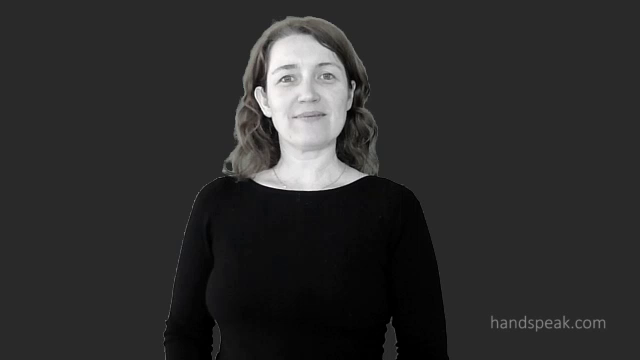

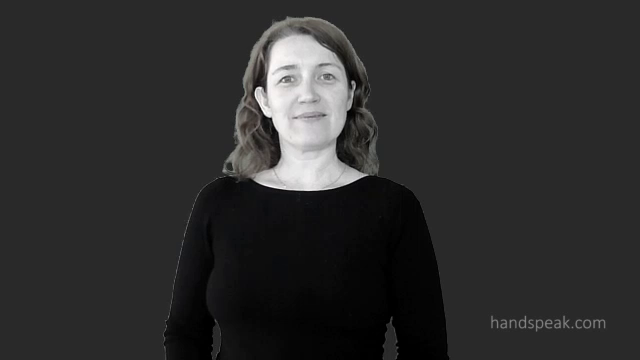

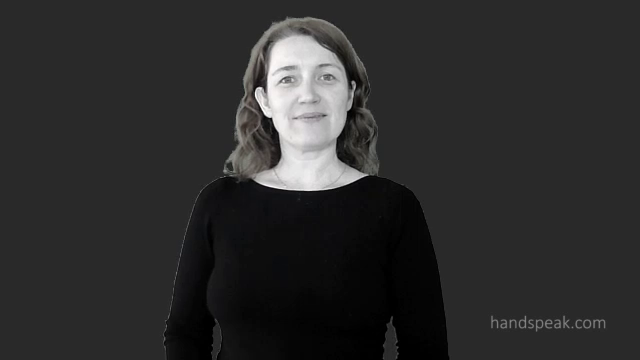

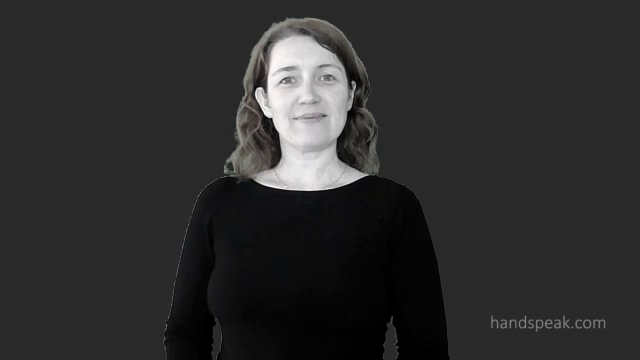

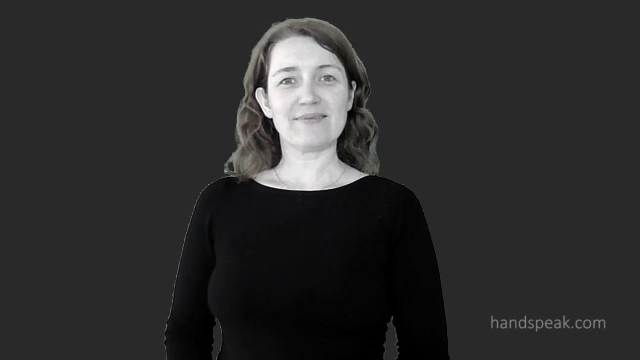

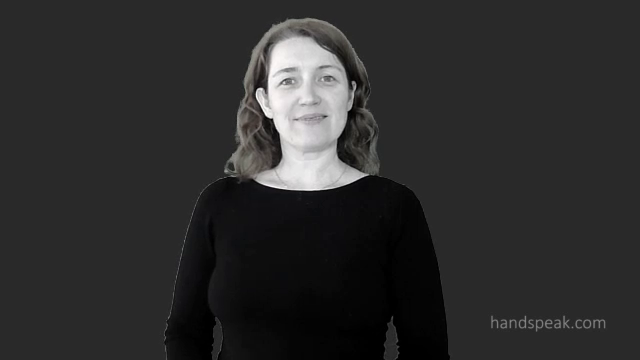

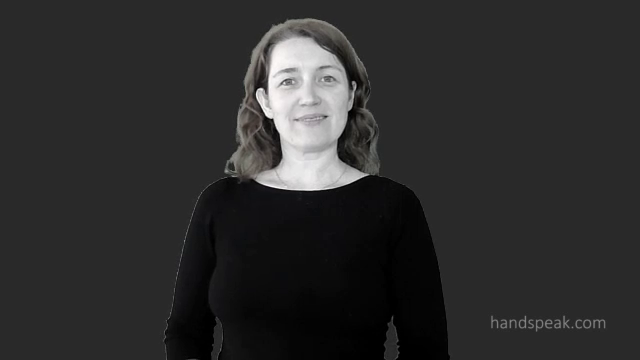

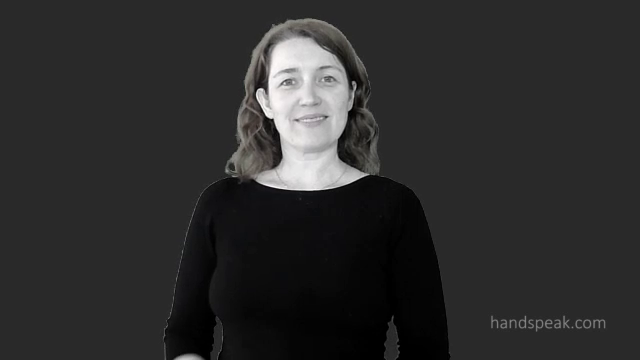

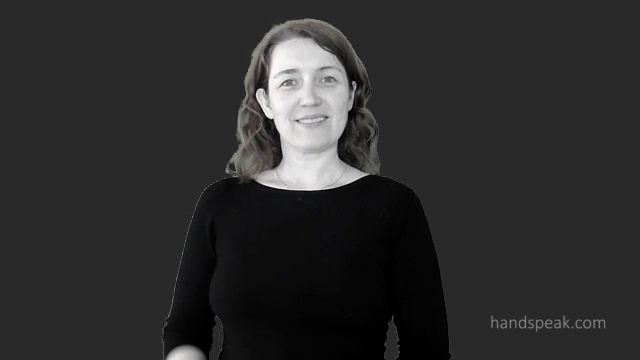

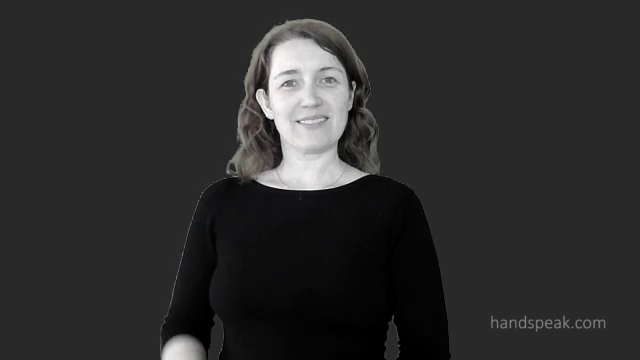

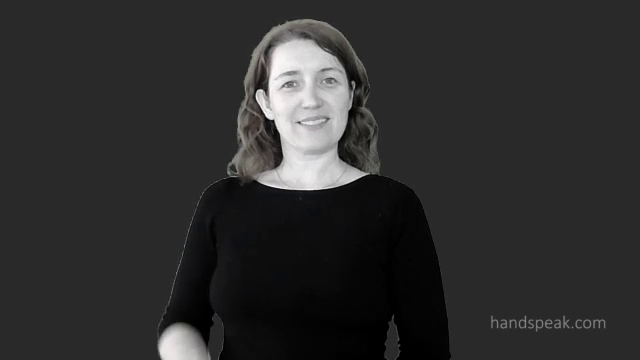

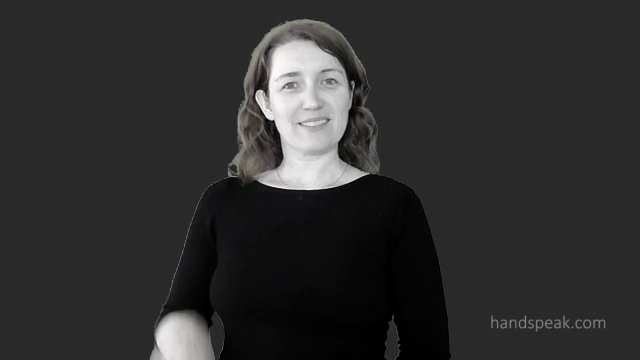

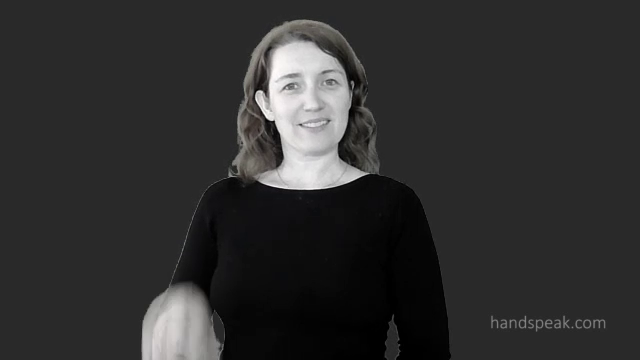

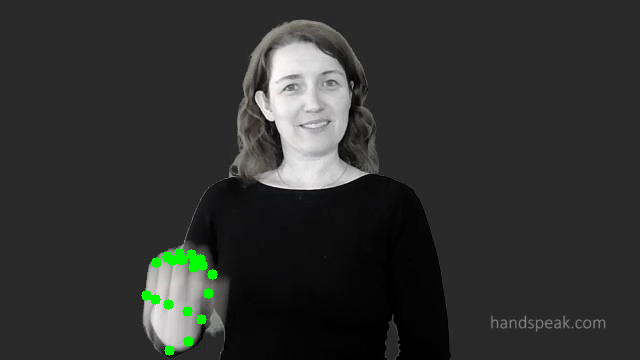

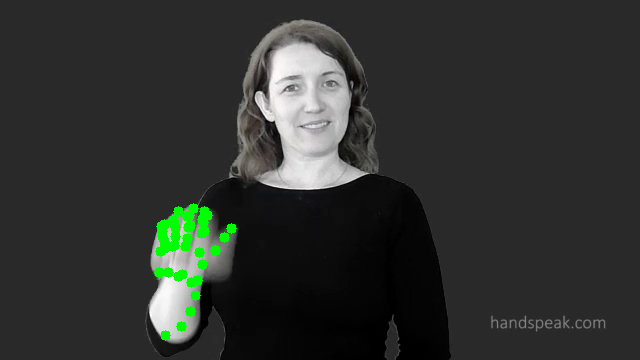

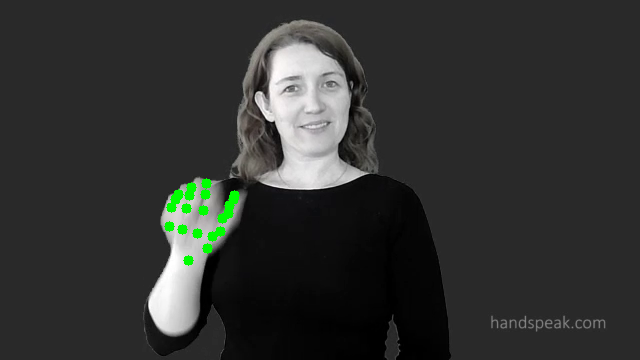

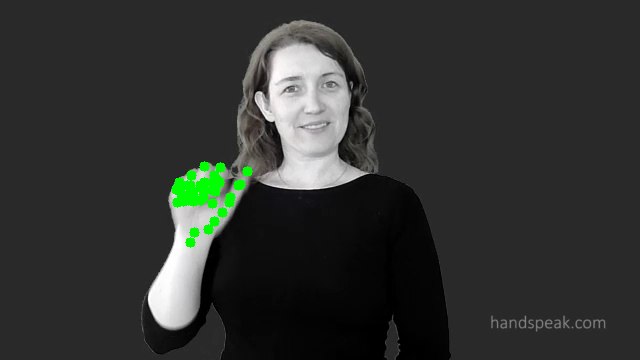

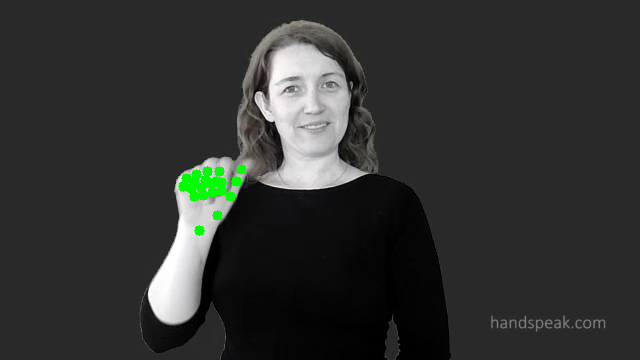

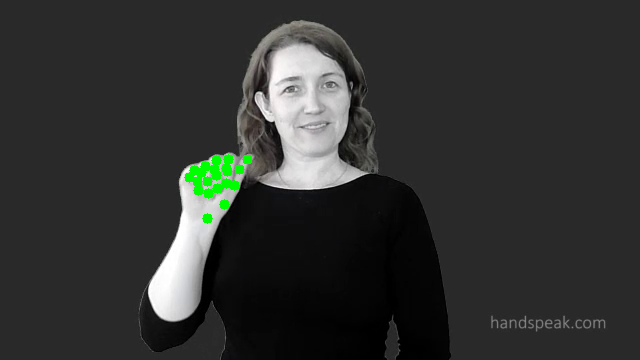

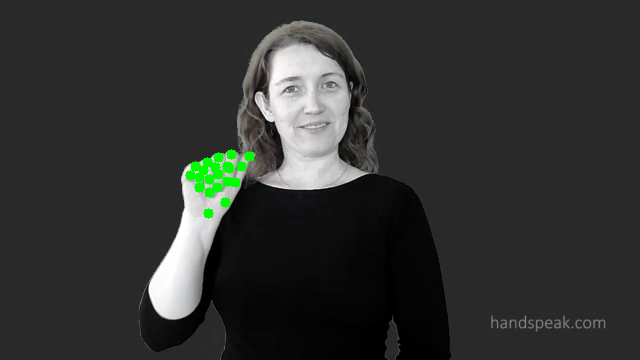

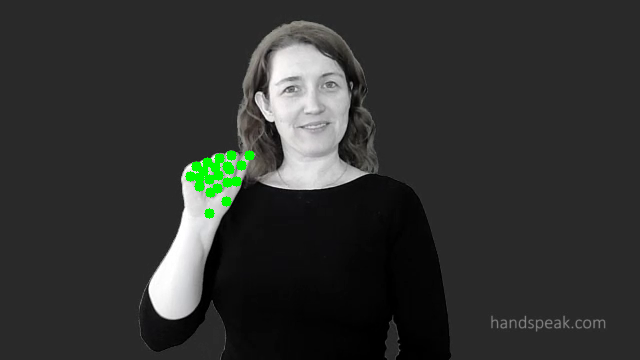

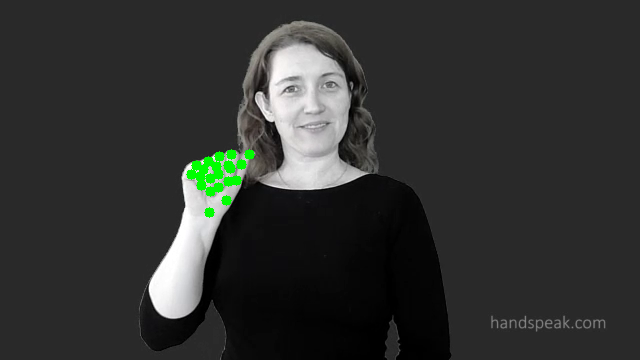

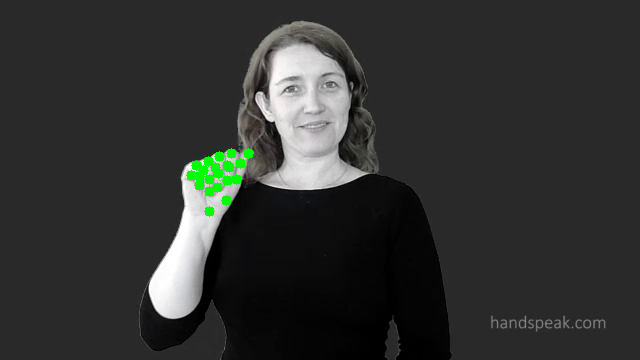

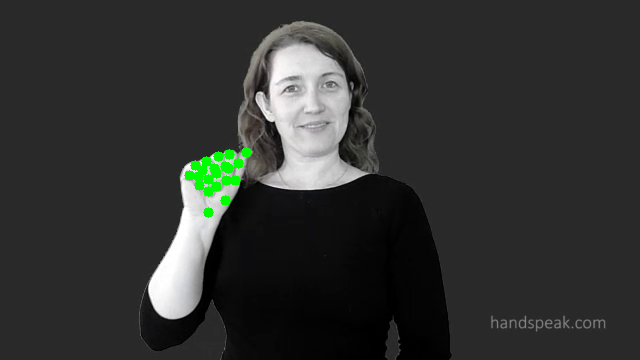

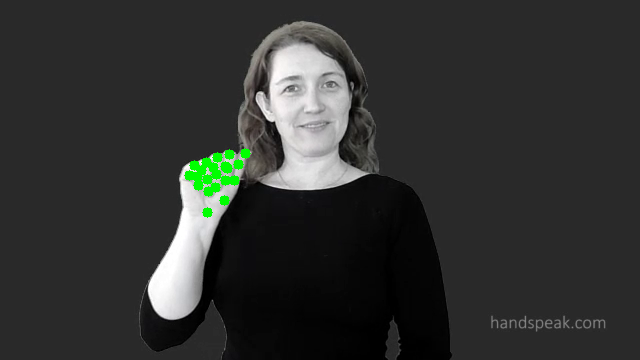

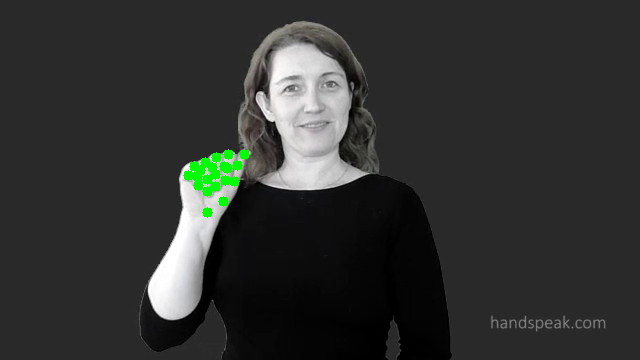

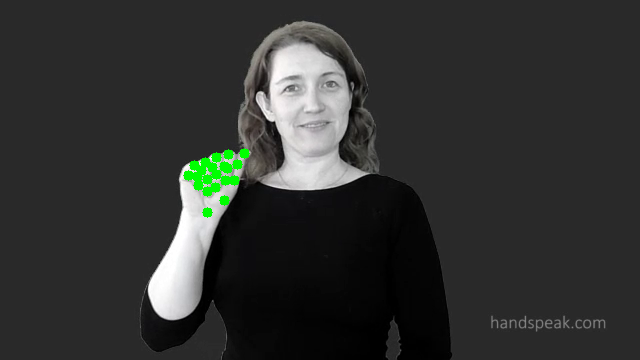

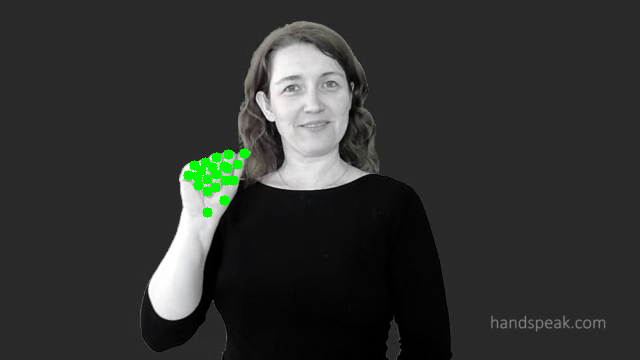

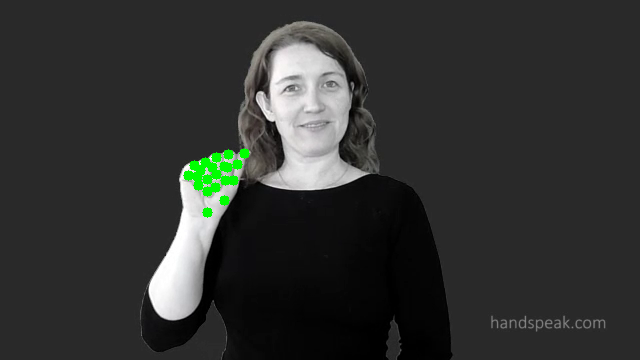

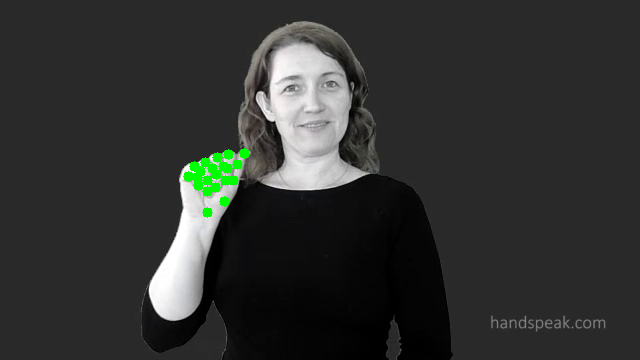

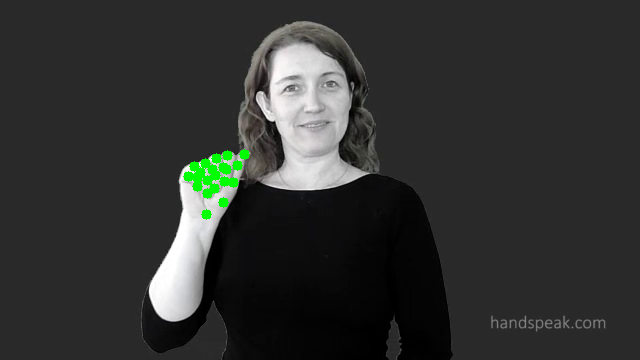

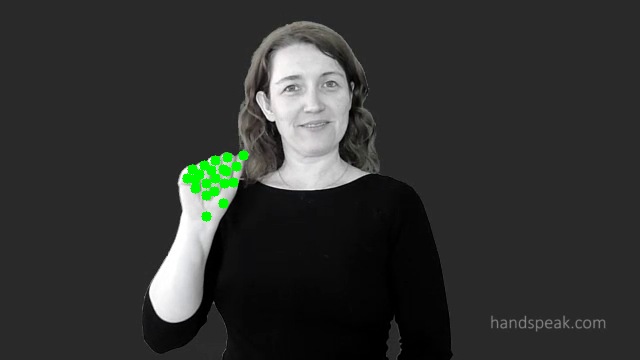

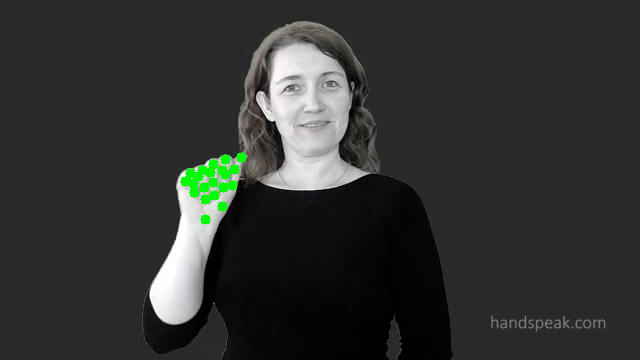

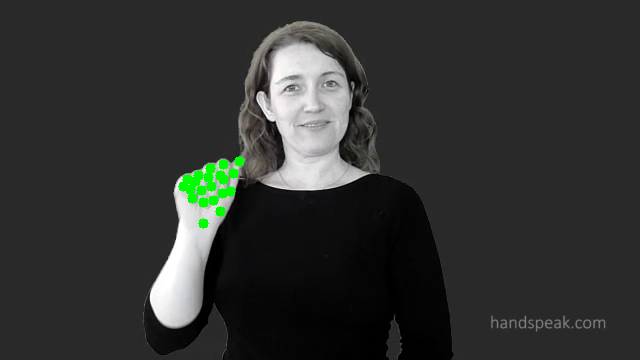

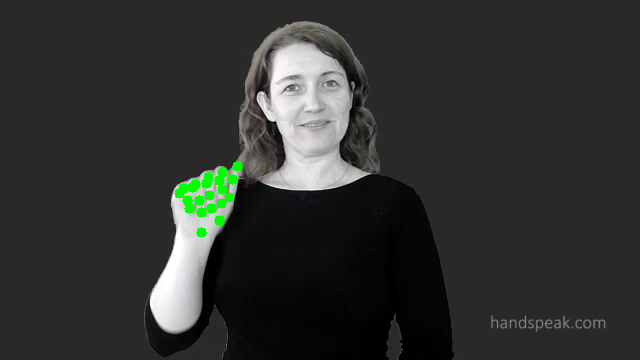

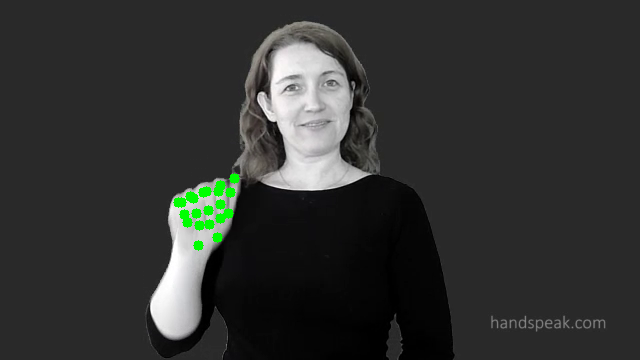

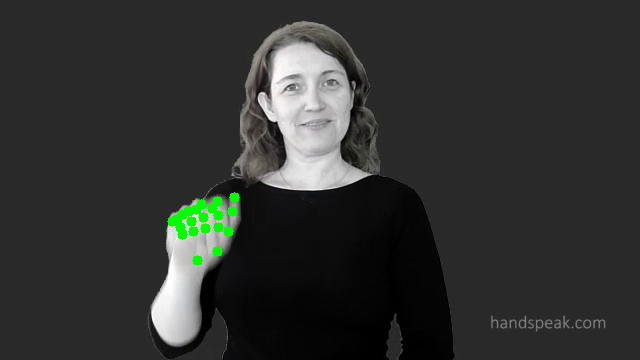

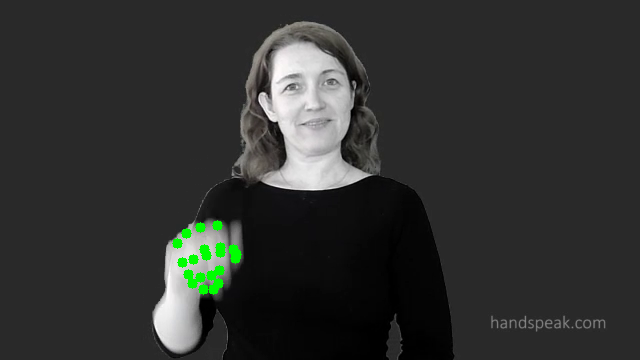

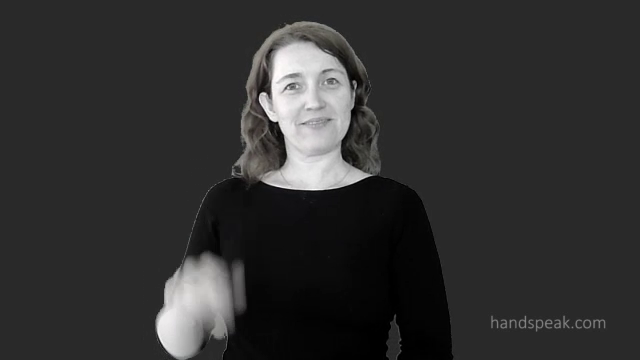

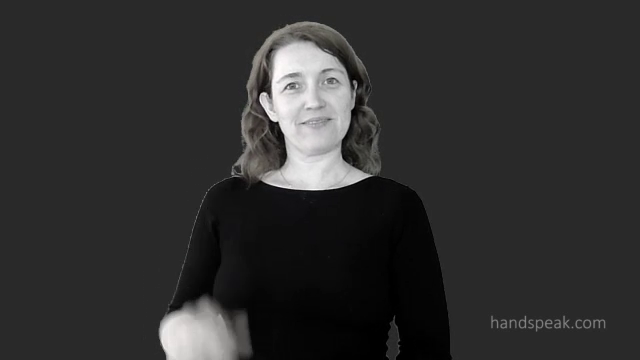

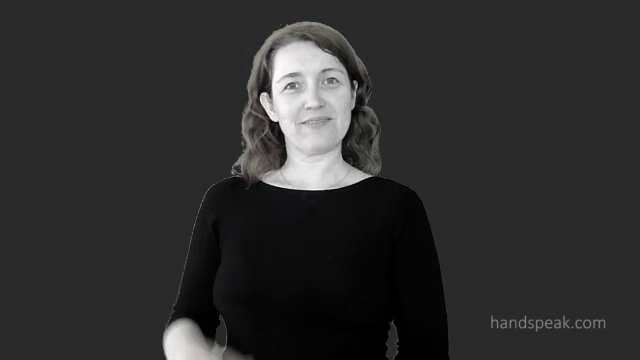

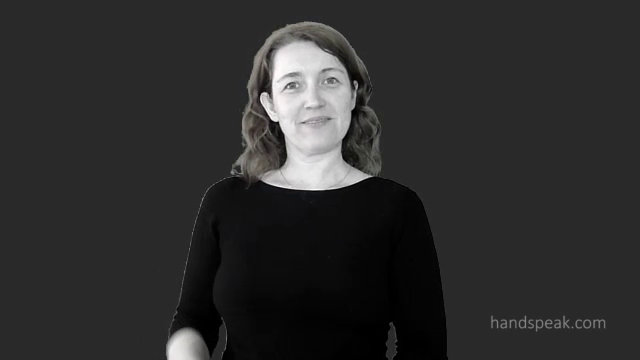

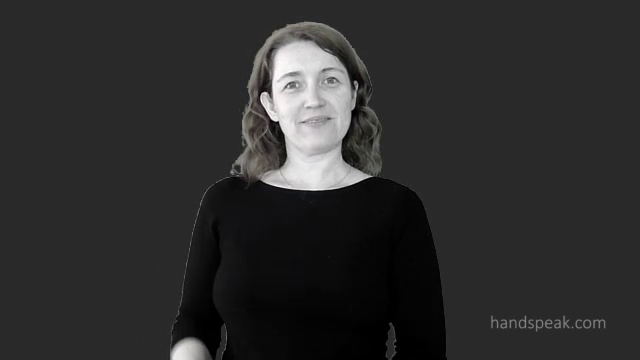

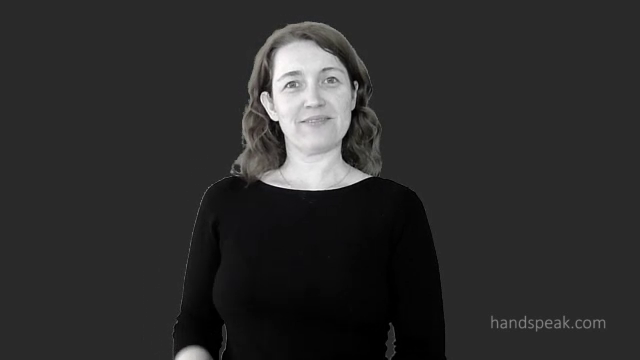

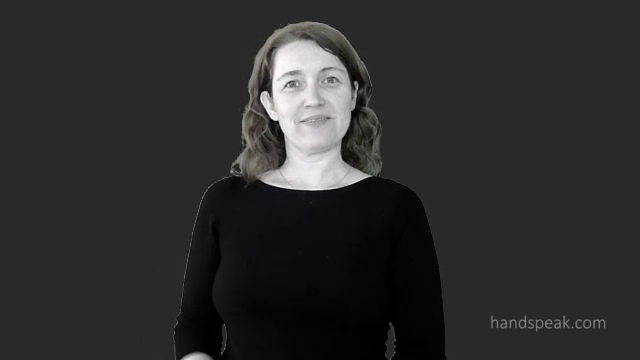

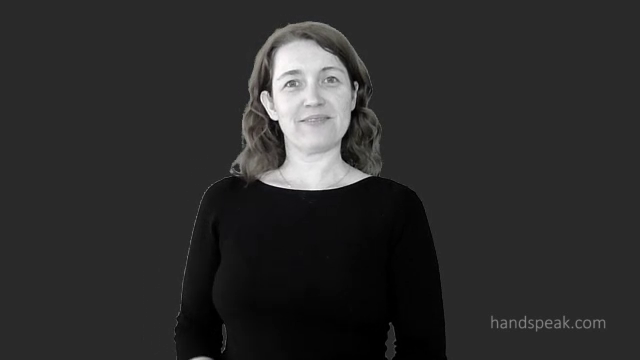

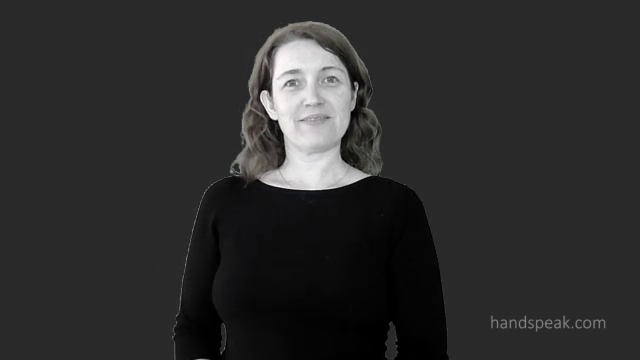

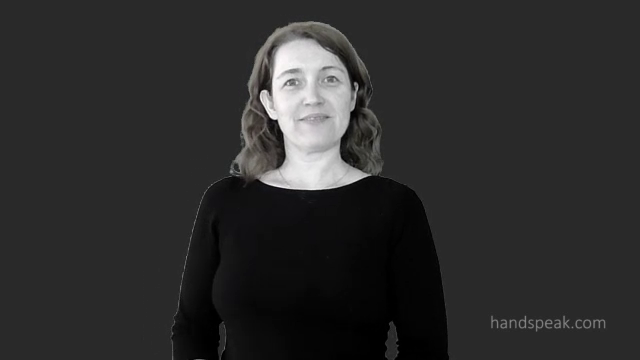

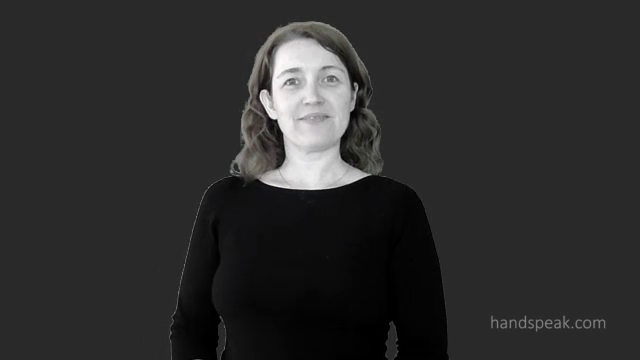

In [ ]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Define video file path
video_path = "/content/drive/MyDrive/WLASL/start_kit/videos/a/01611.mp4"

# Open video file
video = cv2.VideoCapture(video_path)

# Iterate over video frames
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe Hands
    results = hands.process(frame_rgb)

    # Check if hand keypoints are detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Iterate over hand keypoints
            for idx, landmark in enumerate(hand_landmarks.landmark):
                # Access the coordinates of each keypoint
                x = int(landmark.x * frame.shape[1])
                y = int(landmark.y * frame.shape[0])

                # Draw a circle on the frame at the keypoint location
                cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)

    # Display the frame with keypoints
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
video.release()
cv2.destroyAllWindows()